# Introduction using pairwise-comparison data

This notebook provides a gentle introduction to the `choix` library.
We consider the case of pairwise-comparison outcomes between items from some set.

In [1]:
import choix
import networkx as nx
import numpy as np

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In `choix`, items are represented by $n$ consecutive integers $\{0, \ldots, n-1 \}$.
The event "item $i$ wins over item $j$" is represented by the Python tuple `(i, j)`.
Note that the winning item always comes *first* in the tuple.

We start by defining a small dataset of comparison outcomes.

In [2]:
n_items = 5
data = [
    (1, 0), (0, 4), (3, 1),
    (0, 2), (2, 4), (4, 3),
]

This dataset can be visually represented by using a graph:

- each node is an item, and
- there is an edge from node $i$ to node $j$ for every observation "$i$ wins over $j$".

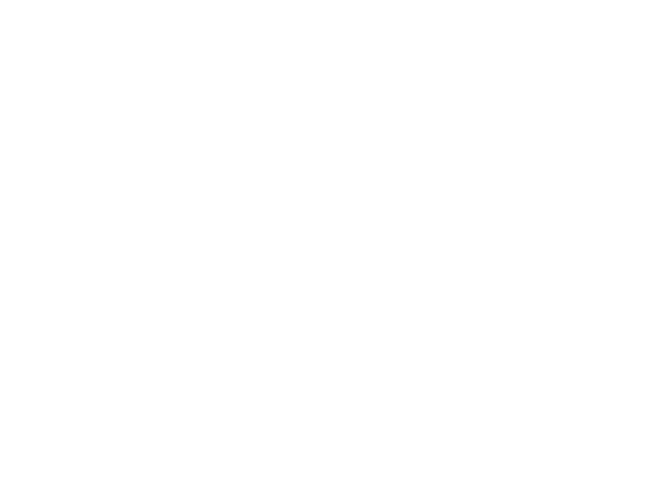

In [3]:
graph = nx.DiGraph(data=data)
nx.draw(graph, with_labels=True)

Suppose that we want to fit a [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) on this data.
`choix` provides several algorithms to do this; below, we use a maximum-likelihood inference algorithm called I-LSR.

In [4]:
params = choix.ilsr_pairwise(n_items, data)
print(params)

[ 0.583  0.194 -0.    -0.194 -0.583]


The parameters can be thought of as the "strength" (or utility) of each item.
It is possible to use them to rank the items: simply order the items by increasing parameter value.

In [5]:
print("ranking (worst to best):", np.argsort(params))

ranking (worst to best): [4 3 2 1 0]


It is also possible to use the parameters to predict outcomes of future comparisons.

In [6]:
prob_1_wins, prob_4_wins = choix.probabilities([1, 4], params)
print("Prob(1 wins over 4): {:.2f}".format(prob_1_wins))

Prob(1 wins over 4): 0.69


## Dealing with sparsity

When the comparison graph is not connected, the maximum-likelihood estimate is not well defined.
This happens for example when one item always wins, or always loses.
In the following example, item $3$ always wins, and item $0$ always loses.

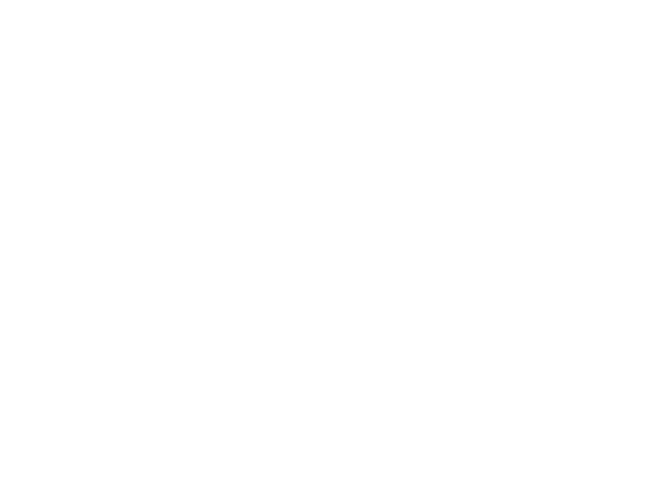

In [11]:
n_items = 4
data = [(3, 2), (2, 1), (1, 0)]

graph = nx.DiGraph(data=data)
nx.draw(graph, with_labels=True)

In these cases, most of the estimators will fail by default.

In [12]:
choix.ilsr_pairwise(n_items, data)

/home/bbearce/.virtualenvs/venv3.10.4/lib/python3.10/site-packages/choix/utils.py:18: RuntimeWarning: divide by zero encountered in log
  params = np.log(weights)
/home/bbearce/.virtualenvs/venv3.10.4/lib/python3.10/site-packages/choix/utils.py:19: RuntimeWarning: invalid value encountered in subtract
  return params - params.mean()


RuntimeError: Did not converge after 100 iterations

The problem can be solved by adding a little bit of regularization as follows.

In [8]:
choix.ilsr_pairwise(n_items, data, alpha=0.01)

array([-4.159, -0.979,  1.483,  3.655])